In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.6 MB/s eta 0:00:00


In [ ]:
from datasets import get_dataset_config_names
domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [ ]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [ ]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [ ]:
# iloc[0][0] is accessing the element at the first row and the first column of the DataFrame
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

In [ ]:
dfs["train"]["question"].str.startswith("How").value_counts()[True]

780

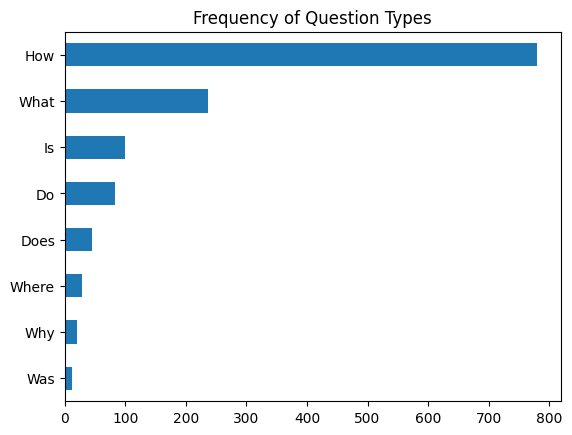

In [ ]:
import matplotlib.pyplot as plt
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]
for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

`dfs["train"].question.str.startswith("How")` -> True, False

`sample` function in pandas is used to randomly select a specified number of rows from a DataFrame

In [ ]:
for question_type in ["How", "What", "Is"]:
  for question in (
      dfs["train"][dfs["train"].question.str.startswith(question_type)]
      .sample(n=3, random_state=42)['question']):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


##Extracting Answers from Text
1. Frame the supervised learning problem.
- framing the problem as a
span classification task, where the start and end tokens of an answer span act as the labels that a model needs to predict. we’ll use a fine-tuned `MiniLM` model since it is fast to train and will allow us to quickly iterate on the techniques

2. Tokenize and encode text for QA tasks.
- `token_type_id` 0 indicates a question token, a 1 indicates a context token.

3. Deal with long passages that exceed a model’s maximum context size.

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
  file size."""
inputs = tokenizer(question, context, return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [ ]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [ ]:
# instantiate the model with a QA head and run the inputs through the forward pass
import torch
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


- ***Start Logits***: Logits representing the likelihood of each token being the start of the answer span.
- ***End Logits***: Logits representing the likelihood of each token being the end of the answer span.
- ***Logits for Each Token***: Each token has associated start and end logits, making it a token classification problem.
- ***Positive Logits*** : Larger, positive logits indicate likely candidates for start and end tokens.
- ***Highest Logits*** : Identify tokens with the highest logits for both start and end.

In [ ]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


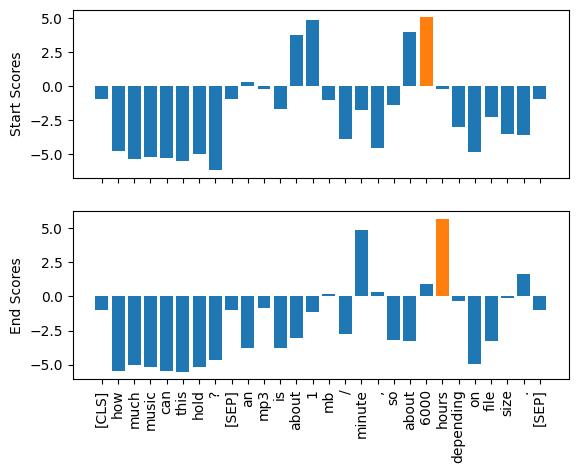

In [ ]:
#hide_input
#id qa-scores
#caption Predicted logits for the start and end tokens—the token with the highest score is colored in orange

# The idea for this visualisation comes from https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

In [ ]:
import torch
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
from transformers import pipeline
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516199111938477,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.2208300083875656,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253503918647766,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

The pipeline not only provides answers but also includes the model's probability estimate in the score field, obtained through softmax over logits. This is useful for comparing multiple answers within a context. The model can predict multiple answers by setting the topk parameter. In cases where no answer is possible, the model assigns elevated scores to the [CLS] token, mapping the output to an empty string in such scenarios.

In [ ]:
pipe(question="Why is there no data?",
     context=context,
     handle_impossible_answer=True)

##Dealing with long passages
`Sliding window` creates multiple question-context pairs for long
documents, set `return_overflowing_tokens=True` in the tokenizer to
enable the sliding window. The size of the sliding window is controlled by the
`max_seq_length` argument, and the size of the stride is controlled by `doc_stride`.

In [ ]:
example = dfs["train"].iloc[0][["question", "context"]]
example

question                                     How is the bass?
context     I have had Koss headphones in the past, Pro 4A...
Name: 0, dtype: object

In [ ]:
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [ ]:
# see where two windows overlap by decoding the inputs
for window in tokenized_example["input_ids"]:
  print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



##Using Haystack to Build a QA Pipeline
if concatenating all the reviews of a given product together and feed them to the model as a single, long context, the context can become
extremely long, unacceptable latency for our users’ queries.
To handle this, modern QA systems are typically based on the:

`Retriever-reader architecture` First: `Retrieving` relevant documents for a given query, then `Reader` extracts an answer from the documents provided by the
retriever.

`Postprocessing`, the retrieved documents may need reranking also reader’s answers when the correct answer comes from various passages
in a long document.

`Haystack` is based on the retriever-reader architecture (Document store + Pipeline)

In [ ]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [ ]:
import os
from subprocess import Popen, PIPE, STDOUT
# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [ ]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "951b6e2ff08d",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "ZyGXYmk8R9qmsB-m_DnyUA",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
!pip install farm-haystack[inference]
!pip install --upgrade haystack

In [ ]:
!pip install farm-haystack[all]

In [ ]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

document_store = ElasticsearchDocumentStore(return_embedding=True)

In [ ]:
for split, df in dfs.items():
# Exclude duplicate reviews
  docs = [{"text": row["context"],
           "meta":{"item_id": row["title"],
          "question_id": row["id"],
                   "split": split}}
          for _,row in df.drop_duplicates(subset="context").iterrows()]
  document_store.write_documents(docs, index="document")
print(f"Loaded {document_store.get_document_count()} documents")

NameError: ignored